In [1]:
import time

import numpy as np
import pandas as pd

import anndata as ad
import scanpy as sc
import squidpy as sq
import matplotlib.pyplot as plt

sc.logging.print_header()
print(f"squidpy=={sq.__version__}")

from markermap.vae_models import MarkerMap, train_model
from markermap.utils import (
    new_model_metrics,
    plot_confusion_matrix,
    split_data,
    plot_umap_embedding
)

from squidpy_markermap import dataset_squidpy, squidpy_markermap, eval_squidpy

from markermap import vae_models
print(vae_models.__file__)
from markermap import utils
print(utils.__file__)

%load_ext autoreload
%autoreload 2

/home/ianubuntu4/.pyenv/versions/miniconda3-latest/envs/BMCS4480/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanpy==1.10.1 anndata==0.10.7 umap==0.5.6 numpy==1.23.4 scipy==1.13.0 pandas==2.2.1 scikit-learn==1.4.2 statsmodels==0.14.1 igraph==0.11.4 louvain==0.8.2 pynndescent==0.5.12
squidpy==1.4.1
scanpy==1.10.1 anndata==0.10.7 umap==0.5.6 numpy==1.23.4 scipy==1.13.0 pandas==2.2.1 scikit-learn==1.4.2 statsmodels==0.14.1 igraph==0.11.4 louvain==0.8.2 pynndescent==0.5.12
squidpy==1.4.1
/home/ianubuntu4/COMPUTER/BMCS4480/final/MarkerMap/src/markermap/vae_models.py
/home/ianubuntu4/COMPUTER/BMCS4480/final/MarkerMap/src/markermap/utils.py
/home/ianubuntu4/COMPUTER/BMCS4480/final/MarkerMap/src/markermap/vae_models.py
/home/ianubuntu4/COMPUTER/BMCS4480/final/MarkerMap/src/markermap/utils.py


## Data

In [2]:
adata, train_dataloader, val_dataloader, train_indices, val_indices, test_indices, train_val_indices = dataset_squidpy()

AnnData object with n_obs × n_vars = 2688 × 18078
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'leiden', 'cluster', 'annotation'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'cluster_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'spatial', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'
(2688, 18078)
(2688,)
['Cortex_1' 'Cortex_2' 'Cortex_3' 'Cortex_4' 'Cortex_5' 'Fiber_tract'
 'Hippocampu

/home/ianubuntu4/COMPUTER/BMCS4480/final/MarkerMap/src/markermap/utils.py:1086: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  torch.utils.data.TensorDataset(torch.Tensor(X), torch.LongTensor(y)),


## Define and train the model

In [4]:
mms = []
markers3 = []
params = {
    'z_size': 16,
    'hidden_layer_size': 64,
    'k': 100,
}
k = [25, 50, 75, 100]

for i in range(0, 7):
    print('k =', k[i])
    params['k'] = k[i]
    tic = time.time()
    mm = squidpy_markermap(params, adata, train_dataloader, val_dataloader)
    toc = time.time()
    print('time_elapsed', toc-tic, 'seconds')
    markers.append(mm.markers().clone().cpu().detach().numpy())

k = 25
{'z_size': 16, 'hidden_layer_size': 64, 'k': 25}
  | Name                   | Type       | Params
------------------------------------------------------
0 | encoder                | Sequential | 1.2 M 
1 | enc_mean               | Linear     | 1.0 K 
2 | enc_logvar             | Linear     | 1.0 K 
3 | decoder                | Sequential | 1.2 M 
4 | dec_logvar             | Sequential | 1.2 M 
5 | weight_creator         | Sequential | 2.3 M 
6 | classification_decoder | Sequential | 2.2 K 
7 | classification_loss    | NLLLoss    | 0     
------------------------------------------------------
5.9 M     Trainable params
0         Non-trainable params
5.9 M     Total params
23.436    Total estimated model params size (MB)


Finding best initial lr: 100%|██████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 181.36it/s]


time_elapsed 33.01144456863403 seconds


in new_model_metrics
train_x shape: (2149, 25)
Y_pred shape (2688,)
in new_model_metrics
train_x shape: (2149, 50)
Y_pred shape (2688,)
in new_model_metrics
train_x shape: (2149, 75)
Y_pred shape (2688,)
in new_model_metrics
train_x shape: (2149, 100)
Y_pred shape (2688,)


Text(0.5, 1.0, 'f1 scores for different values of k')

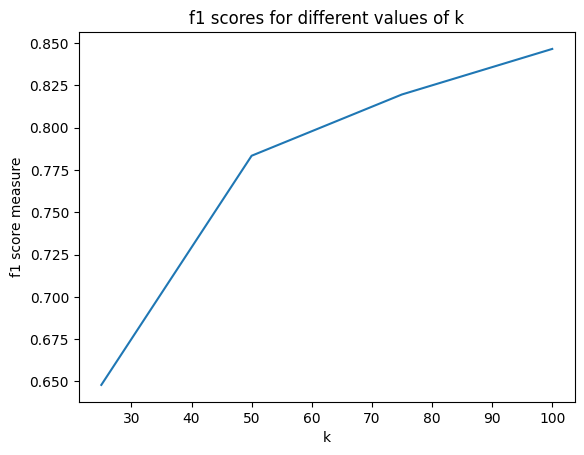

In [64]:
group_by = 'annotation'

f1_scores = []
k = [25, 50, 75, 100]

for i in range(0, 4):
    misclass_rate, test_rep, cm, Y_pred = new_model_metrics(
        adata[train_val_indices, :].X,
        adata[train_val_indices, :].obs[group_by],
        adata[test_indices, :].X,
        adata[test_indices, :].obs[group_by],
        markers = markers3[i],
        X = adata.X
    )
    f1_scores.append(test_rep['weighted avg']['f1-score'])

plt.plot(k, f1_scores)
plt.xlabel('k')
plt.ylabel('f1 score measure')
plt.title('f1 scores for different values of k')